In [1]:
from utils import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load Mesh and Texture File

In [2]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [9]:
# Set paths
DATA_DIR = "../data/datasets"
MESH_DIR = "../data/meshes"
date = "dec_15"
obj_filename = os.path.join(MESH_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

## Change camera R and T params

In [4]:
# R, T changes method
num_views = 10

spin = torch.linspace(0, 0, int(num_views/2))
azim = torch.cat([spin, spin], dim=0)
spin_up = torch.linspace(-89, 89, int(num_views/2))
spin_down = torch.linspace(89, -89, int(num_views/2))
elev = torch.cat([spin_up, spin_down], dim=0)
# forward = torch.linspace(1.5, 2.5, int(num_views/2))
# backward = torch.linspace(2.5, 1.5, int(num_views/2))
# dist = torch.cat([forward, backward], dim=0)
dist = torch.linspace(1.5, 3, num_views)
azim = torch.linspace(0, 180, num_views)

R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
renderer, images, meshes = make_mesh_motion(mesh, R, T, num_views)

# save_images_as_video(images, filename='vids/simple_cow.mp4', fps=25)

AttributeError: 'int' object has no attribute 'type'

In [ ]:
# print(images.shape, (np.array(target_rgb).shape))
cow_filename = 'data/simple_cow'
save_R_T(R, T, cow_filename)
save_images_as_video(images, filename=cow_filename, fps=25)
# save_images_as_video(images, filename='vids/simple_cow.mp4', fps=25)

## Depth Extraction

In [10]:
num_frames = 10
image_size = 512
data_dir = f"../data/datasets/{date}_gens/"
data_filename = 'scratchpad'
# Generate translations and animate the mesh
# mesh_T = generate_circular_translations(num_frames, radius=0.1, height_variation=0.1)
mesh_T = generate_left_right_translations(num_frames, height_variation=0.4)
# mesh_R = generate_rotations(num_frames, rotation_speed=.1)
mesh_R = generate_continuous_spin_rotations(num_frames, rotation_speed=.3)

R, T = look_at_view_transform(2.7, 0, 180) 
# assuming a still camera, so R, T are constant in each frame
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=120)
lights = PointLights(device=device, location=[[0, 0, -3]])
raster_settings = RasterizationSettings(image_size=image_size, blur_radius=0, faces_per_pixel=1)
R = R.repeat(num_frames, 1, 1)
T = T.repeat(num_frames, 1, 1)

rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
shader = SoftPhongShader(device=device, cameras=cameras, lights=lights)
renderer = MeshRendererWithFragments(
        rasterizer=rasterizer,
        shader=shader,
    )

animated_images, animated_depths = animate_mesh_translation(mesh, renderer, mesh_T, mesh_R, device=device)

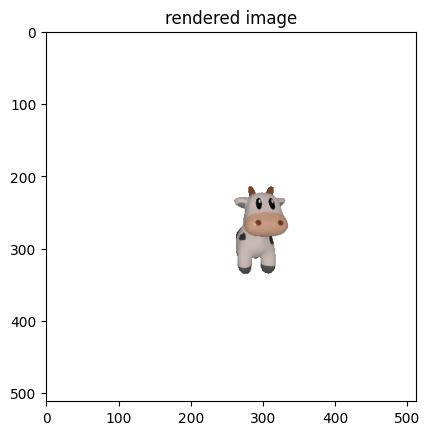

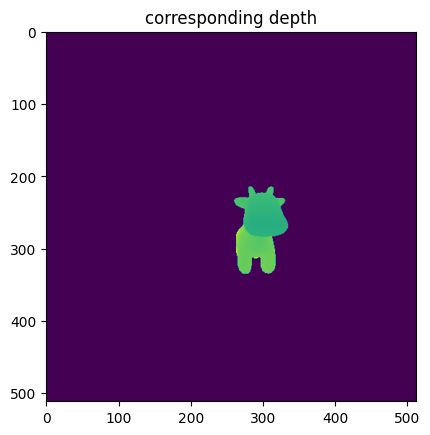

In [11]:
frame = 9
# depth = rasterizer(mesh).zbuf.cpu().squeeze().numpy()
image = animated_images[frame][0, ..., :3]
depth = animated_depths[frame]

plt.imshow(image)
plt.title("rendered image")
plt.show()
plt.imshow(depth)
plt.title("corresponding depth")
plt.show()

In [11]:
print(depth.max(), depth.min())

3.5061765 -1.0


## Deform Meshes Method

In [5]:
num_frames = 20
data_dir = f"../data/datasets/{date}_gens/"
data_filename = 'scratchpad'
# Generate translations and animate the mesh
# mesh_T = generate_circular_translations(num_frames, radius=0.1, height_variation=0.1)
mesh_T = generate_left_right_translations(num_frames, height_variation=0.4)
# mesh_R = generate_rotations(num_frames, rotation_speed=.1)
mesh_R = generate_continuous_spin_rotations(num_frames, rotation_speed=20)

# Animate the mesh
renderer, R, T = setup_renderer(device, num_frames=num_frames)
animated_images, animated_depths = animate_mesh_translation(mesh, renderer, mesh_T, mesh_R, device=device)
animated_images = np.squeeze(np.array(animated_images), axis=1)

# save video and data
save_images_as_video(np.array(animated_images), data_dir = data_dir, filename=data_filename, fps=15)
save_images_as_video(np.array(animated_depths), data_dir = data_dir, filename=data_filename+'_depth', fps=15)
save_mesh_R_T(mesh_R, mesh_T, data_dir = data_dir, filename=data_filename)
save_camera_R_T(R, T, data_dir = data_dir, filename=data_filename)

writing video to:  scratchpad.mp4
writing video to:  scratchpad_depth.mp4


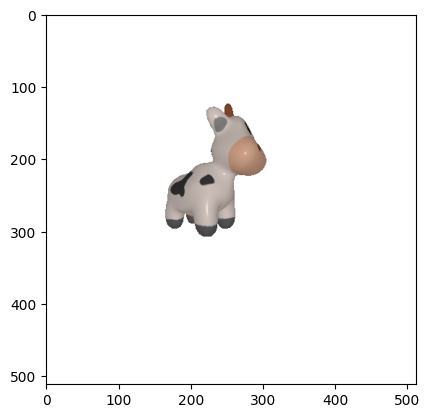

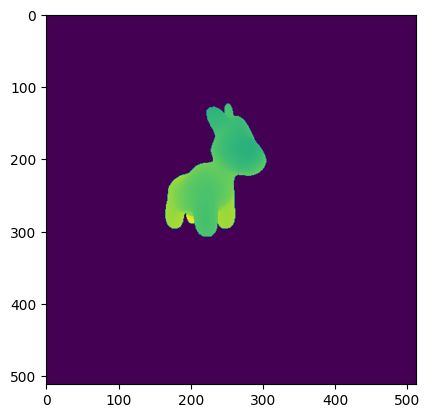

In [9]:
frame = 3
plt.imshow(animated_images[frame][:,:,:3])
plt.show()

plt.imshow(animated_depths[frame])
plt.show()

## Visibility Calculation

abs(zbuf-zcam):  tensor(0.0025)
abs(zbuf-zcam):  tensor(0.0015)
visibilities:  [tensor(True), tensor(True)]
vert coords:  [[224, 207], [250, 207]]


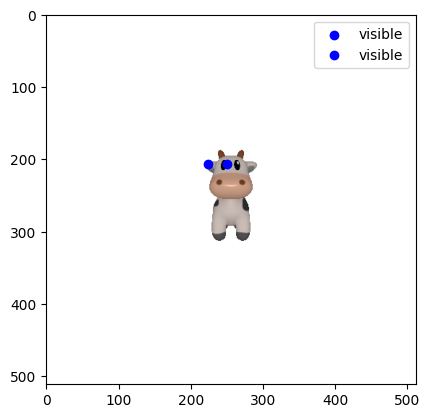

abs(zbuf-zcam):  tensor(0.0022)
abs(zbuf-zcam):  tensor(0.0029)
visibilities:  [tensor(True), tensor(True)]
vert coords:  [[215, 182], [249, 185]]


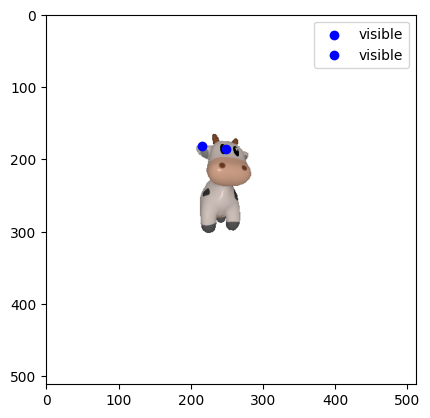

abs(zbuf-zcam):  tensor(0.0038)
abs(zbuf-zcam):  tensor(0.0002)
visibilities:  [tensor(True), tensor(True)]
vert coords:  [[216, 154], [257, 166]]


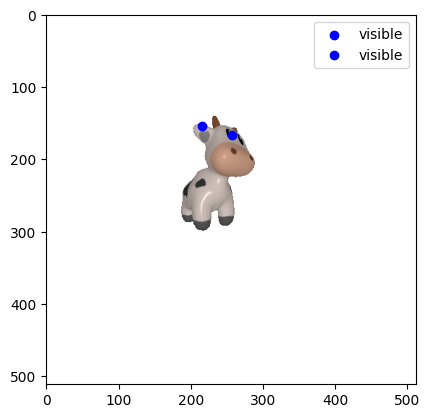

In [31]:
mesh_instance = mesh.clone()
h, w = 512, 512
# verts = [952, 2475]
# verts = [1349, 1240]
verts = [1234, 1349]
# nose_vert_idx = 1069

for frame in range(3):
    # get mesh instance at current frame 
    rotation = mesh_R[frame]
    translation = mesh_T[frame]
    transform = Transform3d().translate(*translation).rotate_axis_angle(angle=rotation, axis="Y")
    transformed_verts = transform.transform_points(mesh.verts_packed()) 
    mesh_instance = Meshes(verts=[transformed_verts], faces=[mesh.faces_packed()], textures=mesh.textures)
    
    # get image at frame
    image, fragments = renderer(mesh_instance)
    plt.imshow(image[0][:,:,:3])

    # visibility
    visibilities, vert_coords = get_vert_visibilities(mesh_instance, renderer, verts, h, w)
    for is_visible, p_coord in zip(visibilities, vert_coords):
        if is_visible:
            plt.scatter(p_coord[0], p_coord[1], c='b', label='visible')
        else:
            plt.scatter(p_coord[0], p_coord[1], c='r', label='occluded')
    
    plt.legend()
    plt.show()

## Nouveau data saving process (w/ verts!!)

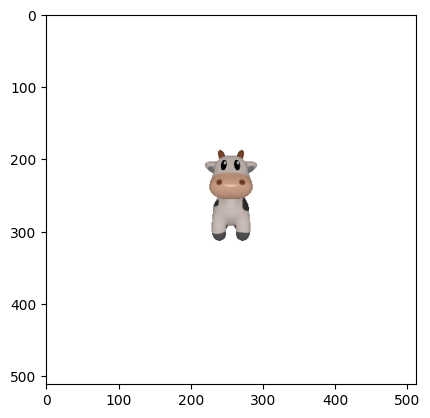

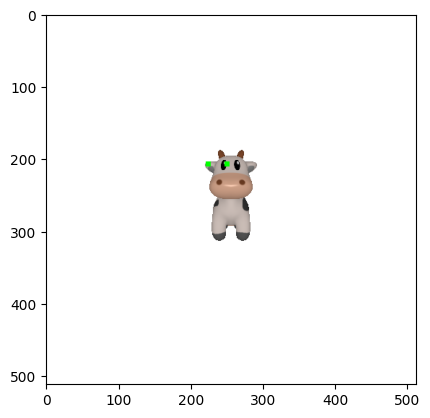

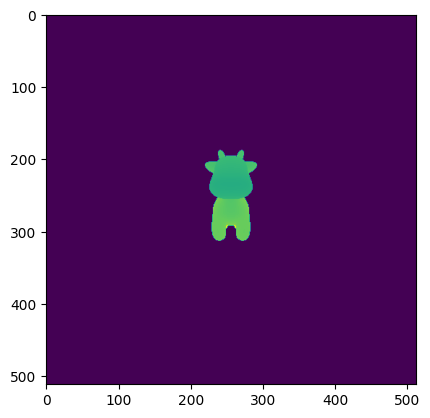

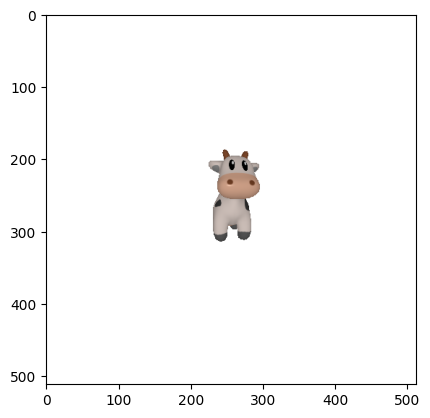

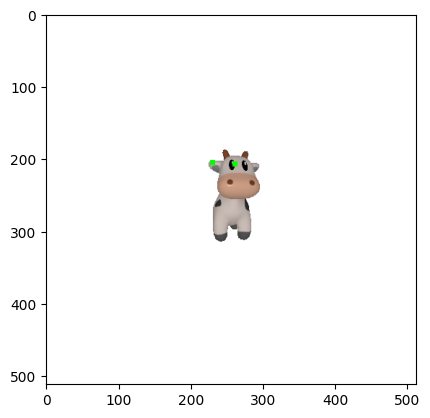

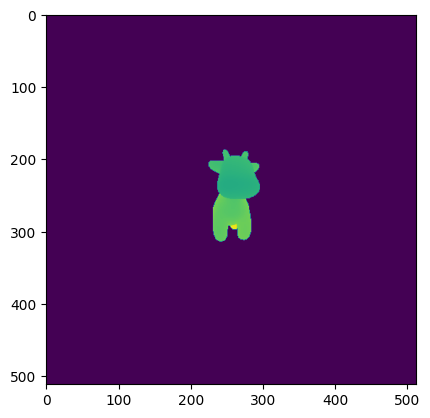

In [12]:
def get_vert_visibilities(mesh_instance, renderer, verts, h, w, eps=1e-2):
    # Transform vertices to camera space
    world_to_view_transform = renderer.rasterizer.cameras.get_world_to_view_transform()
    view_verts = world_to_view_transform.transform_points(mesh_instance.verts_packed())
    S_cam = renderer.rasterizer.cameras.transform_points_screen(mesh_instance.verts_packed(), image_size=(h, w))

    visibilities, vert_coords = [], []
    for vert_idx in verts:
        
        # get vertex in camera space
        zcam = view_verts[vert_idx, 2]
        
        # Get pixel coordinates corresponding to the vertex of interest
        p_cam = S_cam[vert_idx]
        p_x, p_y = int(p_cam[0]), int(p_cam[1])

        # Step 2: Render the scene to extract z-buffer
        _, fragments = renderer(mesh_instance)
        zbuf = fragments.zbuf[0, p_y, p_x, 0]  # Ensure that indices p_x and p_y are not swapped

        # Step 3: Determine visibility
        is_visible = abs(zbuf-zcam)<eps

        visibilities.append(is_visible)
        vert_coords.append([p_x, p_y])
    
    return np.array(visibilities), np.array(vert_coords)

def change_neighborhood_color(image, x, y, color, neighborhood_size=3):
    """
    Change the color of a neighborhood of pixels around a point (x, y) in the image.
    """
    h, w, channels = image.shape
    for i in range(-neighborhood_size, neighborhood_size + 1):
        for j in range(-neighborhood_size, neighborhood_size + 1):
            if 0 <= x + i < w and 0 <= y + j < h:
                image[y + j, x + i, :3] = color  # Update only the first three channels (RGB)

def animate_mesh_vert_translation(mesh, renderer, translations, rotations, verts, device=torch.device("cpu")):
    rendered_images = []
    rendered_depths = []
    rendered_vert_images = []
    rendered_visibilities = []
    rendered_vert_coords = []

    for translation, rotation in zip(translations, rotations):
        # Create a new mesh with the transformed vertices
        transform = Transform3d().translate(*translation).rotate_axis_angle(angle=rotation, axis="Y")
        transformed_verts = transform.transform_points(mesh.verts_packed())
        transformed_mesh = Meshes(verts=[transformed_verts], faces=[mesh.faces_packed()], textures=mesh.textures)

        # Render the transformed mesh
        image = np.squeeze(renderer(transformed_mesh)[0], axis=0).numpy()  # Convert to numpy array
        depth = renderer(transformed_mesh)[1].zbuf.squeeze().numpy()
        rendered_images.append(image.copy())
        rendered_depths.append(depth)

        # get vertex coords + visibilities
        visibilities, vert_coords = get_vert_visibilities(transformed_mesh, renderer, verts, h=depth.shape[0], w=depth.shape[1])
        rendered_visibilities.append(visibilities)
        rendered_vert_coords.append(vert_coords)

        vert_image = image.copy()
        for is_visible, p_coord in zip(visibilities, vert_coords):
            color = [0, 1, 0] if is_visible else [1, 0, 0]  # Green if visible, Red if not
            change_neighborhood_color(vert_image, p_coord[0], p_coord[1], color)
        rendered_vert_images.append(vert_image)

        # Optionally, display the image
        plt.imshow(image[:,:,:3])
        plt.show()
        plt.imshow(vert_image[:,:,:3])
        plt.show()
        plt.imshow(depth)
        plt.show()

    return rendered_images, rendered_depths, rendered_vert_images, rendered_visibilities, rendered_vert_coords

def save_vis(verts, visibilities, vert_coords, data_dir=None, filename='vert'):
    torch.save(verts, os.path.join(data_dir, filename+'_verts.pt'))
    torch.save(visibilities, os.path.join(data_dir, filename+'_visibilities.pt'))
    torch.save(vert_coords, os.path.join(data_dir, filename+'_coords.pt'))

data_dir = f"../data/datasets/{date}_gens/"
video_data_dir = data_dir + 'videos/'
filename = 'vert_vis'
num_frames = 2
verts = [1234, 1349]

# Generate translations and animate the mesh
mesh_T = generate_left_right_translations(num_frames)
mesh_R = generate_continuous_spin_rotations(num_frames, rotation_speed=10)
renderer, R, T = setup_renderer(device, num_frames=num_frames)

# produce animation and save as video
animated_images, animated_depths, animated_vert_images, animated_visibilities, animated_vert_coords = animate_mesh_vert_translation(mesh, renderer, mesh_T, mesh_R, verts)
# animated_images = np.squeeze(np.array(animated_images), axis=1)
masked_images = np.array([add_mask_to_image_frame(frame, (1,0,0)) for frame in animated_images])

# save as video etc etc 
save_images_as_video(np.array(animated_images), data_dir = video_data_dir, filename=filename, fps=15)
save_images_as_video(np.array(animated_vert_images), data_dir = video_data_dir, filename=filename+'_verts', fps=15)
save_images_as_video(np.array(masked_images), data_dir = video_data_dir, filename=filename+'_masked', fps=15)
save_images_as_video(np.array(animated_depths), data_dir = video_data_dir, filename=filename+'_depth', fps=15)

save_mesh_R_T(mesh_R, mesh_T, data_dir = data_dir, filename=filename)
save_camera_R_T(R, T, data_dir = data_dir, filename=filename)
save_vis(verts, animated_visibilities, animated_vert_coords, data_dir = data_dir, filename=filename)

(512, 512, 4)


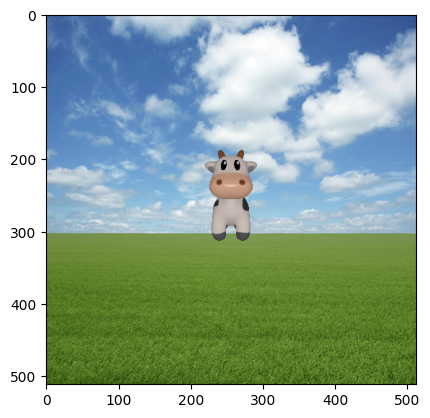

In [73]:
from PIL import Image

mask_path = 'data/cow_mesh/grass.png'

print(animated_images[0].shape)
new_image = add_mask_to_image_frame(animated_images[0], mask_path)
plt.imshow(new_image[:,:,:3])


## zoomin in

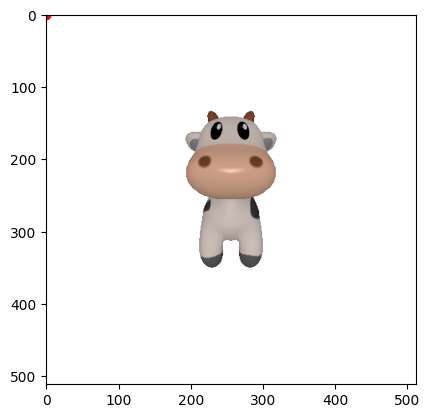

In [80]:
R, T = look_at_view_transform(1.75, 0, 180) 

# assuming a still camera, so R, T are constant in each frame
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=120)
lights = PointLights(device=device, location=[[0, 0, -3]])
raster_settings = RasterizationSettings(image_size=(512,512), blur_radius=0, faces_per_pixel=1)
R = R.repeat(num_frames, 1, 1)
T = T.repeat(num_frames, 1, 1)

renderer2 = MeshRendererWithFragments(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
)

test_im = renderer2(mesh)[0]
plt.imshow(test_im[0][:,:,:3])
plt.scatter(0,0, c='r')

## rendering out a vertex on spot herself!

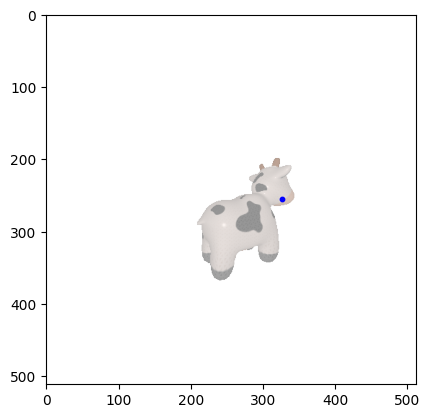

(tensor(326.2012), tensor(254.3452))

In [102]:
def generate_vert_from_frame(mesh, renderer, mesh_R, mesh_T, vert_idx, frame):
    vertices = mesh.verts_packed()
    vertex = vertices[vert_idx].reshape(1, -1)

    # get to proper image frame
    mesh_rotation, mesh_translation = mesh_R[frame], mesh_T[frame]
    transform = Transform3d().translate(*mesh_translation).rotate_axis_angle(angle=mesh_rotation, axis="Y")
    vertex = transform.transform_points(vertex.reshape(1, -1))

    cam = renderer.rasterizer.cameras
    [x_image, y_image, z_image] = cam.transform_points_screen(vertex, image_size=(512, 512))[0]

    return x_image, y_image, z_image

def generate_vert_track(mesh, renderer, mesh_R, mesh_T, vert_idx, frame_list):
    x_coords, y_coords, z_coords = [], [], []
    for frame in frame_list:
        x, y, z = generate_vert_from_frame(mesh, renderer, mesh_R, mesh_T, vert_idx, frame)
        x_coords.append(x)
        y_coords.append(y)
        z_coords.append(z)
    return x_coords, y_coords, z_coords

def plot_vert(mesh, renderer, mesh_R, mesh_T, vert_idx, frame, animated_images):
    
    x_image, y_image, z_image = generate_vert_from_frame(mesh, renderer, mesh_R, mesh_T, vert_idx, frame)

    # plot image
    plt.imshow(animated_images[frame])
    
    plt.scatter(x_image, y_image, c='b', s=10)
    plt.show()
    return x_image, y_image

# plot nose
vert_idx = 376
plot_vert(mesh, renderer, mesh_R, mesh_T, vert_idx, 12, animated_images)
# for frame in range(len(animated_images)):
# for frame in range(10):
#     plot_vert(mesh, renderer, mesh_R, mesh_T, vert_idx, frame, animated_images)


Text(0.5, 1.0, 'nose coordinates!')

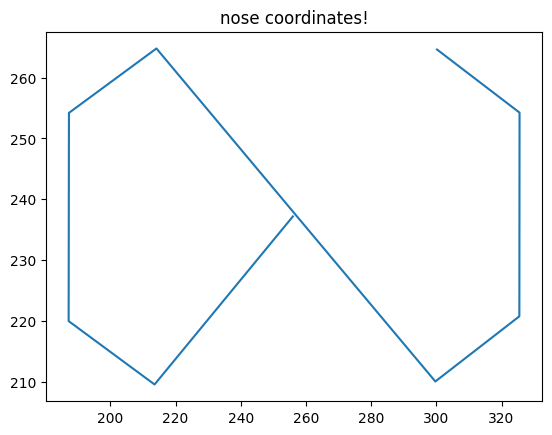

In [61]:
x_coords, y_coords, z_coords = generate_vert_track(mesh, renderer, mesh_R, mesh_T, vert_idx, range(len(mesh_R)))
plt.plot(x_coords, y_coords)
plt.title("nose coordinates!")

In [17]:
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# import matplotlib
# from matplotlib.animation import PillowWriter

# def plot_test_particle_track(title, animated_images, mesh, renderer, mesh_R, mesh_T, vert_idx=376):
#     def update_plot(frame, mesh, renderer, mesh_R, mesh_T, vert_idx, fig, ax, animated_images):
#         x_image, y_image, z_image = generate_vert_from_frame(mesh, renderer, mesh_R, mesh_T, vert_idx, frame)

#         # Check if the image data is valid
#         if len(animated_images[frame][0].shape) not in [2, 3]:
#             print(f"Invalid image shape at frame {frame}: {animated_images[frame][0].shape}")
#             return ax

#         ax.clear()
#         ax.imshow(animated_images[frame][0])

#         # Plotting the point based on z_image value
#         color = 'r' if z_image < 0 else 'b'
#         ax.scatter(x_image, y_image, c=color, s=10)

#         return ax

#     fig, ax = plt.subplots()

#     num_frames = len(mesh_R)

#     ani = FuncAnimation(fig, update_plot, frames=range(num_frames),
#                         fargs=(mesh, renderer, mesh_R, mesh_T, vert_idx, fig, ax, animated_images),
#                         blit=False, repeat=False)

#     Writer = matplotlib.animation.writers['ffmpeg']
#     writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

#     if os.path.isdir(data_dir):
#         pass
#     else:
#     # The directory does not exist
#         os.mkdir(data_dir)
#     ani.save(title, writer=writer)

#     plt.close(fig)

# title = data_dir + '/animated_video.mp4'
# plot_test_particle_track(title, animated_images, mesh, renderer, mesh_R, mesh_T, vert_idx)


In [110]:
# def generate_vert_from_frame(mesh, renderer, mesh_R, mesh_T, vert_idx, frame):
#     vertices = mesh.verts_packed()
#     vertex = vertices[vert_idx].reshape(1, -1)

#     mesh_rotation, mesh_translation = mesh_R[frame], mesh_T[frame]
#     transform = Transform3d().translate(*mesh_translation).rotate_axis_angle(angle=mesh_rotation, axis="Y")
#     transformed_verts = transform.transform_points(vertices)

#     # Ensure correct shape for verts
#     if transformed_verts.dim() == 2:
#         transformed_verts = transformed_verts.unsqueeze(0)

#     # Ensure correct shape for faces
#     faces = mesh.faces_packed()
#     if faces.dim() == 2:
#         faces = faces.unsqueeze(0)

#     # Create the transformed mesh
#     transformed_mesh = Meshes(verts=transformed_verts, faces=faces)

#     rendered_output, fragments = renderer(transformed_mesh)
#     zbuf = fragments.zbuf.squeeze()

#     cam = renderer.rasterizer.cameras
#     screen_vertex = cam.transform_points_screen(vertex, image_size=(512, 512))[0]
#     x_image, y_image, z_image = screen_vertex

#     x_pixel, y_pixel = int(x_image), int(y_image)
#     is_visible = z_image < zbuf[y_pixel, x_pixel]

#     return x_image, y_image, is_visible

# def update_plot(frame, mesh, renderer, mesh_R, mesh_T, vert_idx, fig, ax, animated_images):
#     x_image, y_image, is_visible = generate_vert_from_frame(mesh, renderer, mesh_R, mesh_T, vert_idx, frame)

#     if len(animated_images[frame].shape) not in [2, 3]:
#         print(f"Invalid image shape at frame {frame}: {animated_images[frame].shape}")
#         return ax

#     ax.clear()
#     ax.imshow(animated_images[frame])

#     # Color based on visibility
#     color = 'b' if is_visible else 'r'
#     ax.scatter(x_image, y_image, c=color, s=10)

#     return ax

# def plot_test_particle_track(title, animated_images, mesh, renderer, mesh_R, mesh_T, vert_idx=376):
#     fig, ax = plt.subplots()
#     num_frames = len(mesh_R)

#     ani = FuncAnimation(fig, update_plot, frames=range(num_frames),
#                         fargs=(mesh, renderer, mesh_R, mesh_T, vert_idx, fig, ax, animated_images),
#                         blit=False, repeat=False)

#     Writer = matplotlib.animation.writers['ffmpeg']
#     writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

#     ani.save(title, writer=writer)
#     plt.close(fig)

# # Usage example
# title = data_dir + '/animated_video.mp4'
# plot_test_particle_track(title, animated_images, mesh, renderer, mesh_R, mesh_T, vert_idx)

## Now Load Some Data!

In [6]:
date

'dec_15'

In [9]:
from utils import * 

device = torch.device("cpu")
cow_filename = 'test2'
data_dir = f'data/{date}_gens/{cow_filename}/GT'
# load mesh
mesh = load_objs_as_meshes(['data/cow_mesh/cow.obj'], device=device)

# load R,T matrices
mesh_R, mesh_T = load_R_T(os.path.join(data_dir, cow_filename+"_mesh"))
renderer, R, T = setup_renderer(device, num_frames=len(mesh_R))

num_frames = len(R)
for frame in range(num_frames):
    # step0: get mesh instance at current frame 
    rotation = mesh_R[frame]
    translation = mesh_T[frame]
    transform = Transform3d().translate(*translation).rotate_axis_angle(angle=rotation, axis="Y")
    transformed_verts = transform.transform_points(mesh.verts_packed()) 
    mesh_instance = Meshes(verts=[transformed_verts], faces=[mesh.faces_packed()], textures=mesh.textures)
    
    # Step 1: Transform vertex to camera space
    world_to_view_transform = renderer.rasterizer.cameras.get_world_to_view_transform()
    view_verts = world_to_view_transform.transform_points(mesh_instance.verts_packed())
    zcam = view_verts[nose_vert_idx, 2]

    # Get pixel coordinates corresponding to the vertex of interest
    S_cam = renderer.rasterizer.cameras.transform_points_screen(mesh_instance.verts_packed(), image_size=(h, w))
    p_cam = S_cam[nose_vert_idx]
    p_x, p_y = int(p_cam[0]), int(p_cam[1])

    # Step 2: Render the scene to extract z-buffer
    image, fragments = renderer(mesh_instance)
    zbuf = fragments.zbuf[0, p_y, p_x, 0]  # Ensure that indices p_x and p_y are not swapped
    # print(f"zbuf: {zbuf}; zcam: {zcam}; diff: {abs(zbuf-zcam)}")
    
    plt.imshow(image[0][:,:,:3])
    # Step 3: Determine visibility
    if is_visible:
        plt.scatter(p_x, p_y, c='b', label='visible')
    else:
        plt.scatter(p_x, p_y, c='r', label='occluded')
    
    plt.legend()
    plt.show()

# renderer, images, mesh = make_mesh_motion(mesh, R, T)
# save_images_as_video(images, filename='data/IMPORTED_SCRIPT', fps=25)

11


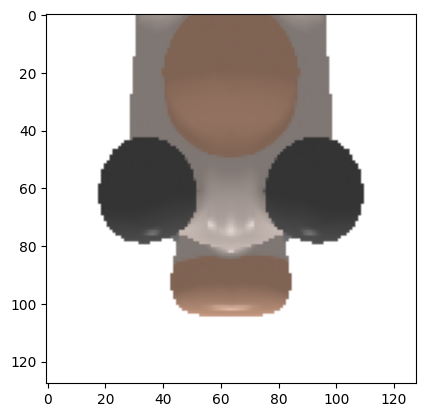

In [ ]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

plt.imshow(images[0, ..., :3])
plt.show()

verts = mesh.verts_packed()
mesh.verts = torch.zeros_like(verts)[None]

In [ ]:
# ok now render two meshes!! 
mesh1 = load_objs_as_meshes(['data/cow_mesh/cow.obj'], device=device)
mesh2 = load_objs_as_meshes(['data/cow_mesh/cow.obj'], device=device)

# load R,T matrices
R1, T1 = load_R_T('data/there_back')


In [ ]:
# verts, faces_idx, _ = load_obj(obj_filename)
# faces = faces_idx.verts_idx

# # Initialize each vertex to be white in color.
# verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
# textures = TexturesVertex(verts_features=verts_rgb.to(device))

# # Create a Meshes object
# mesh = Meshes(
#     verts=[verts.to(device)],   
#     faces=[faces.to(device)],
#     textures=textures
# )



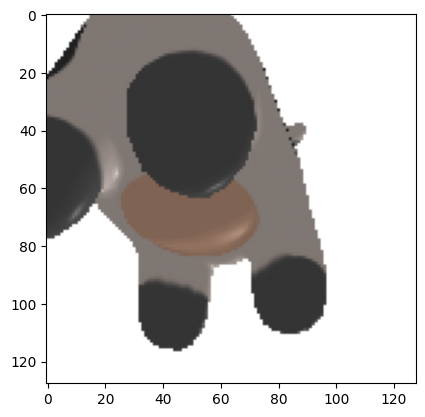

In [ ]:
# loading attempt
mesh_filename = 'vids/simple_cow_meshes.pt'
R_filename = 'vids/simple_cow_R.pt'
T_filename = 'vids/simple_cow_T.pt'

mesh_2 = load_objs_as_meshes([obj_filename], device=device)
R_2 = torch.load(R_filename)
T_2 = torch.load(T_filename)

print()

# meshes_2 = mesh_2.extend(150)
renderer_2, images_2, meshes_2 = make_mesh_motion(mesh=mesh_2, R=R_2, T=T_2)
images_2 = renderer_2(meshes_2)

plt.imshow(images_2[0, ..., :3].cpu().numpy())